In [1]:
%pip install scikitplot

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement scikitplot (from versions: none)

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: No matching distribution found for scikitplot


In [1]:
%matplotlib inline
import dtreeviz
from feature_engine import encoding, imputation
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import base, compose, datasets, ensemble, \
metrics, model_selection, pipeline, preprocessing, tree
#import scikitplot
import xgboost as xgb
import yellowbrick.model_selection as ms
from yellowbrick import classifier
import urllib
import zipfile
import xg_help as xhelp
url = 'https://github.com/mattharrison/datasets/raw/master/data/'\
'kaggle-survey-2018.zip'
fname = 'kaggle-survey-2018.zip'
member_name = 'multipleChoiceResponses.csv'

In [2]:
raw = xhelp.extract_zip(url, fname, member_name)
## Create raw X and raw y
kag_X, kag_y = xhelp.get_rawX_y(raw, 'Q6')
## Split data
kag_X_train, kag_X_test, kag_y_train, kag_y_test = \
model_selection.train_test_split(
kag_X, kag_y, test_size=.3, random_state=42, stratify=kag_y)
## Transform X with pipeline
X_train = xhelp.kag_pl.fit_transform(kag_X_train)
X_test = xhelp.kag_pl.transform(kag_X_test)
## Transform y with label encoder
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(kag_y_train)
y_train = label_encoder.transform(kag_y_train)
y_test = label_encoder.transform(kag_y_test)
# Combined Data for cross validation/etc
X = pd.concat([X_train, X_test], axis='index')
y = pd.Series([*y_train, *y_test], index=X.index)

c:\VSC\XGBoost\xg_help.py:73: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
c:\VSC\XGBoost\xg_help.py:102: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
c:\VSC\XGBoost\xg_help.py:103: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
c:\VSC\XGBoost\xg_help.py:104: FutureWarning: Downcasting behavior in `replace` 

In [3]:
%pip install hyperopt

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
from hyperopt import fmin, tpe, hp, Trials
params = {'random_state': 42}

rounds = [{'max_depth': hp.quniform('max_depth', 1, 8, 1), # tree
'min_child_weight': hp.loguniform('min_child_weight',-2, 3)},
{'subsample': hp.uniform('subsample', 0.5, 1), # stochastic
'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1)},
{'reg_alpha': hp.uniform('reg_alpha', 0, 10),
'reg_lambda': hp.uniform('reg_lambda', 1, 10),},
{'gamma': hp.loguniform('gamma',-10, 10)}, # regularization
{'learning_rate': hp.loguniform('learning_rate',-7, 0)} # boosting
]

all_trials = []

for round in rounds:
    params = {**params, **round}
    trials = Trials()
    best = fmin(fn=lambda space: xhelp.hyperparameter_tuning(space, X_train,
    y_train, X_test, y_test),
    space=params,
    algo=tpe.suggest,
    max_evals=20,
    trials=trials,
    )

    params = {**params, **best}
    all_trials.append(trials)

100%|██████████| 20/20 [00:08<00:00,  2.46trial/s, best loss: -0.7679558011049724]


In [11]:
params

{'random_state': 42,
 'max_depth': np.float64(7.0),
 'min_child_weight': np.float64(0.3638721992620582),
 'subsample': np.float64(0.9541588255902028),
 'colsample_bytree': np.float64(0.9005088173561906),
 'reg_alpha': np.float64(1.1509009716010998),
 'reg_lambda': np.float64(6.888451226311975),
 'gamma': np.float64(0.00019105311684257514),
 'learning_rate': np.float64(0.16296810435894274)}

In [12]:
step_params = {'random_state': 42,
 'max_depth': np.int64(7.0),
 'min_child_weight': np.float64(0.3638721992620582),
 'subsample': np.float64(0.9541588255902028),
 'colsample_bytree': np.float64(0.9005088173561906),
 'reg_alpha': np.float64(1.1509009716010998),
 'reg_lambda': np.float64(6.888451226311975),
 'gamma': np.float64(0.00019105311684257514),
 'learning_rate': np.float64(0.16296810435894274)}

In [13]:
xg_step = xgb.XGBClassifier(**step_params, early_stopping_rounds=50,
 n_estimators=500)
xg_step.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train),(X_test, y_test)],
    verbose=100
 )

[0]	validation_0-logloss:0.65157	validation_1-logloss:0.65357
[100]	validation_0-logloss:0.36814	validation_1-logloss:0.50338


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=np.float64(0.9005088173561906), device=None,
              early_stopping_rounds=50, enable_categorical=False,
              eval_metric=None, feature_types=None, feature_weights=None,
              gamma=np.float64(0.00019105311684257514), grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=np.float64(0.16296810435894274), max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=np.int64(7), max_leaves=None,
              min_child_weight=np.float64(0.3638721992620582), missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_parallel_tree=None, ...)

In [14]:
xg_step.score(X_test, y_test)

0.7569060773480663

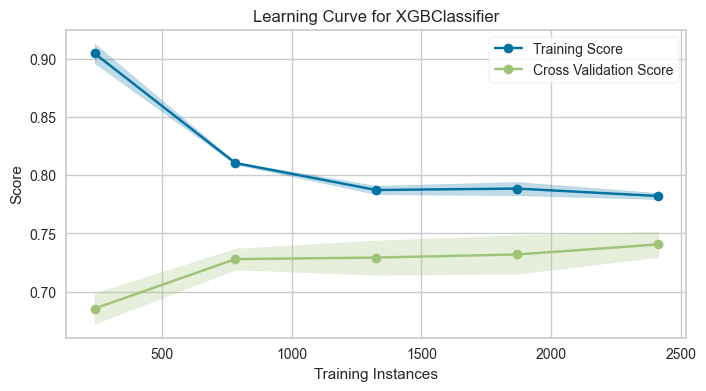

(0.6, 1.0)

In [ ]:
 params = {'learning_rate': 0.3,
 'max_depth': 2,
 'n_estimators': 200,
 'n_jobs':-1,
 'random_state': 42,
 'reg_lambda': 0,
 'subsample': 1}

 import yellowbrick.model_selection as ms
 fig, ax = plt.subplots(figsize=(8, 4))
 viz = ms.learning_curve(xgb.XGBClassifier(**params),
 X, y, ax=ax
 )
 ax.set_ylim(0.6, 1)